In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import seaborn as sns                            

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from statsmodels.graphics.api import qqplot

%matplotlib inline

In [185]:
df = pd.read_csv('SN_d_tot_V2.0.csv', sep=';', header=None)
df.columns = ['year', 'month','day', 'FracDate', 'Sunspots', 'Std', 'Observations', 'Verified']
df = df[['year','month','day', 'Sunspots']]
df['Date'] = df.apply(lambda row: datetime(
                              int(row['year']), int(row['month']),int(row['day'])), axis=1)

df['Date'] = pd.to_datetime(df["Date"])
df_idx = df.set_index(["Date"], drop=True)

daily_sun= df[['Date','Sunspots']]#df.head()
daily_sun = daily_sun.set_index(["Date"], drop=True)


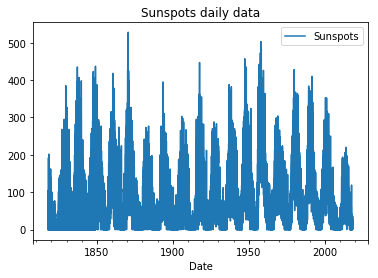

In [186]:
daily_sun = daily_sun.sort_index(axis=1, ascending=True)
data = daily_sun[['Sunspots']]
data.plot(y='Sunspots')
plt.title('Sunspots daily data')
plt.show()

In [187]:
diff = data.index.values[-1] - data.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 1749 to %d"%(1818 + int(0.8*years)))

Total data: 200 years
80 percent data = 1749 to 1978


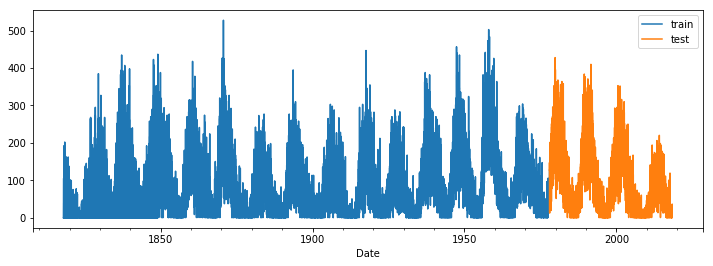

In [188]:
split_date = pd.Timestamp('01-01-1978')

train = data.loc[:split_date]
test = data.loc[split_date:]
ax = train.plot(figsize=(12,4))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

In [189]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [190]:
len(train_sc),len(test_sc)

(58440, 14761)

In [191]:
s=3960
#s=1
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_'+str(s), axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_'+str(s), axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

In [192]:
len(X_test)

10801

In [193]:
len(y_test)

10801

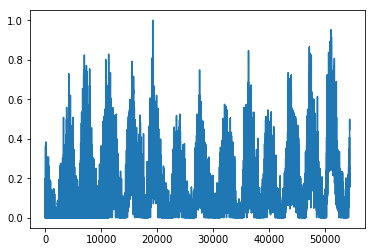

In [194]:
plt.plot(X_train)

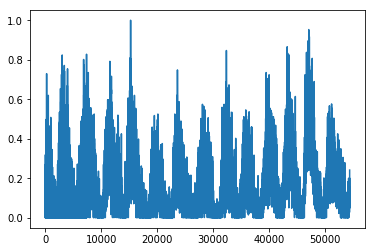

In [195]:
plt.plot(y_train)

In [196]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

In [197]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

Epoch 1/10
54480/54480 [==============================] - 60s 1ms/step - loss: 0.0423
Epoch 2/10
54480/54480 [==============================] - 42s 764us/step - loss: 0.0167
Epoch 3/10
54480/54480 [==============================] - 42s 776us/step - loss: 0.0165
Epoch 4/10
54480/54480 [==============================] - 42s 774us/step - loss: 0.0165
Epoch 5/10
54480/54480 [==============================] - 37s 674us/step - loss: 0.0165
Epoch 6/10
54480/54480 [==============================] - 38s 705us/step - loss: 0.0165
Epoch 7/10
54480/54480 [==============================] - 38s 699us/step - loss: 0.0165
Epoch 8/10
54480/54480 [==============================] - 36s 660us/step - loss: 0.0165
Epoch 9/10
54480/54480 [==============================] - 39s 720us/step - loss: 0.0165
Epoch 10/10
54480/54480 [==============================] - 38s 700us/step - loss: 0.0165


In [198]:
y_pred = model.predict(X_test)#*2.1-0.17
y_pred2 = model.predict(X_train)#*2.1-0.17

R-Squared: 0.321580


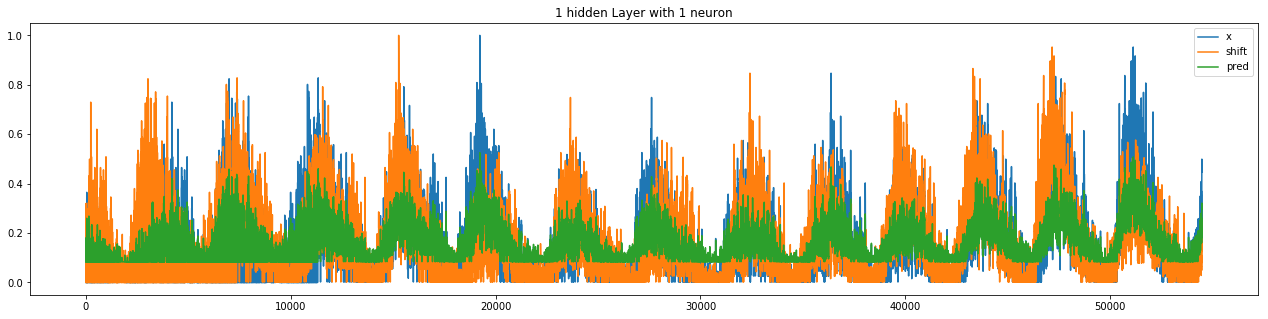

In [199]:
plt.figure(figsize=(22,5))

plt.plot(X_train)
plt.plot(y_train)
plt.plot(y_pred2)

# plt.plot(X_train)
# plt.plot(y_pred2)
plt.legend(['x', 'shift','pred'])
plt.title('1 hidden Layer with 1 neuron')
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

R-Squared: 0.321580


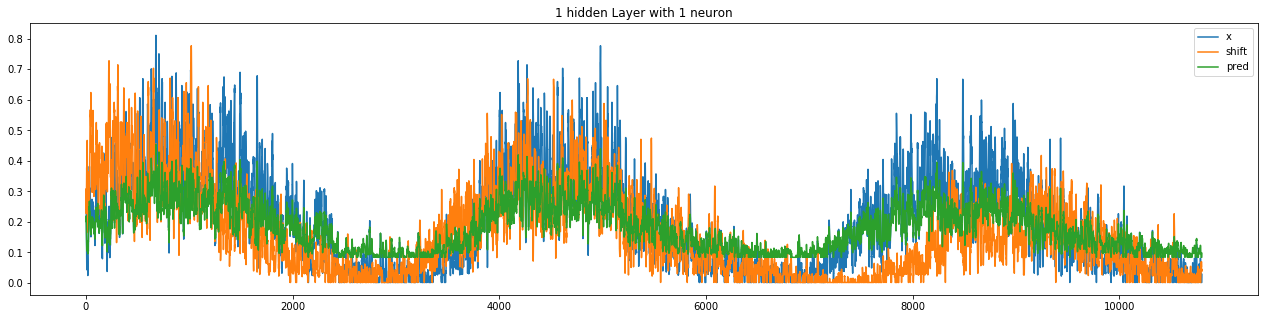

In [200]:
plt.figure(figsize=(22,5))

plt.plot(X_test)
plt.plot(y_test)
plt.plot(y_pred)

# plt.plot(X_train)
# plt.plot(y_pred2)
plt.legend(['x', 'shift','pred'])
plt.title('1 hidden Layer with 1 neuron')
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

In [201]:
len(train)

58440

In [202]:
len(X_train)+s

58440

In [203]:
len(X_test)

10801

In [204]:
len(test)

14761

In [205]:
len(y_pred2)+len(y_pred)+s+len(y_pred3)

73201

In [206]:
len(data)

73200

In [207]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


In [208]:
rmse(y_pred, y_test)

0.11648854973190294

In [209]:
rmse(X_test,y_pred)

0.0862915749597951

In [210]:
rmse(y_pred2,y_train )

0.12849426279721884

In [211]:
rmse(X_train,y_train )

0.15028512074278136

In [212]:
y_pred3 = model.predict(y_test[-s:]) #*2.1-0.17

Text(0.5,1,'1 hidden Layer with 1 neuron')

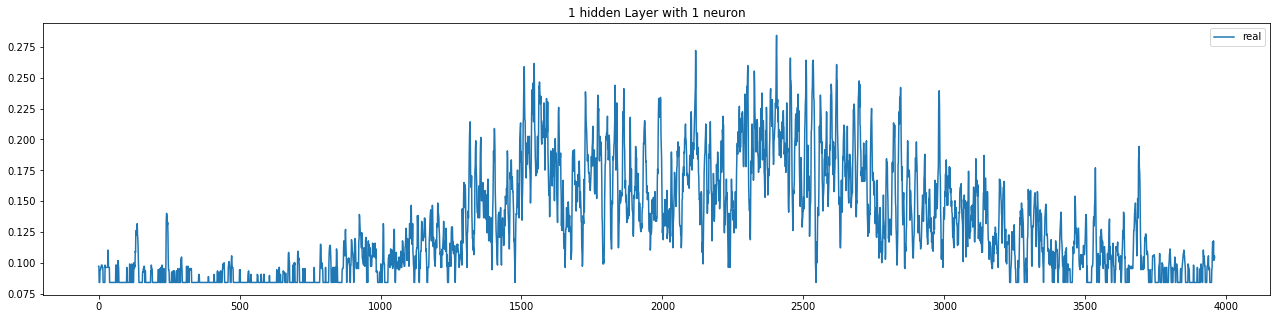

In [213]:
plt.figure(figsize=(22,5))



plt.plot(y_pred3)

# plt.plot(X_train)
# plt.plot(y_pred2)
plt.legend(['real', 'ann model'])
plt.title('1 hidden Layer with 1 neuron')


In [214]:
totalpred = np.concatenate((np.zeros((s,1)),y_pred2,y_pred,y_pred3))

In [215]:
y_pred.shape

(10801, 1)

69241

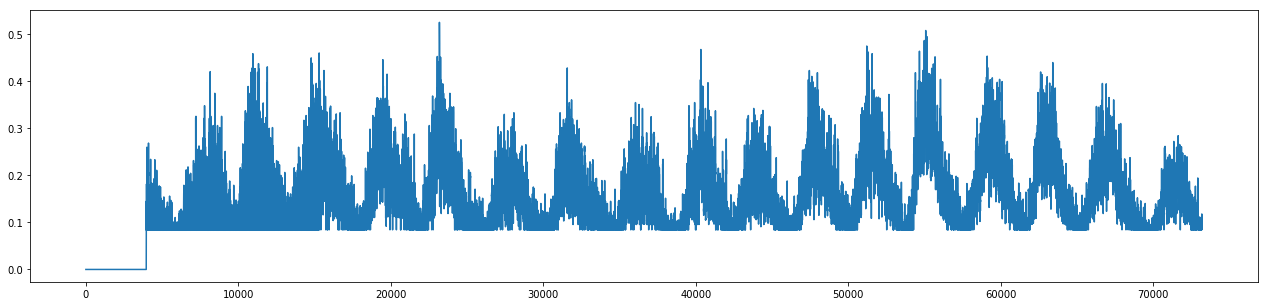

In [216]:
plt.figure(figsize=(22,5))

plt.plot(totalpred)
len(y_pred2)+len(y_pred)+len(y_pred3)

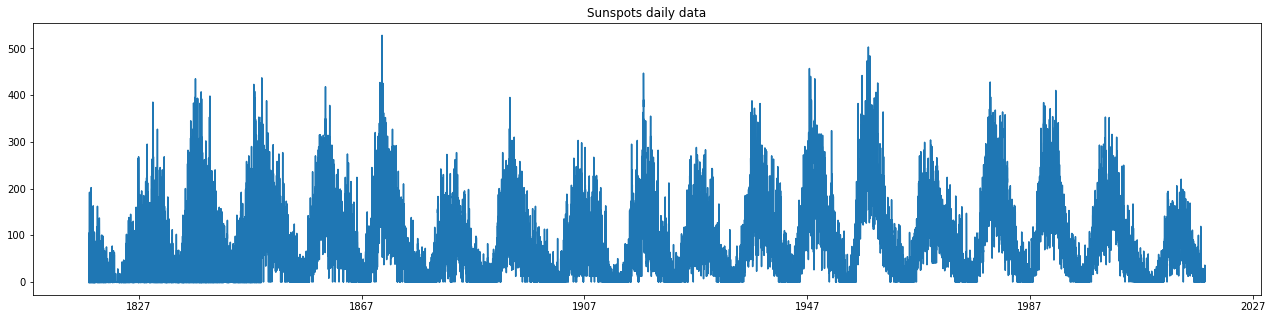

In [217]:
daily_sun = daily_sun.sort_index(axis=1, ascending=True)
data = daily_sun[['Sunspots']]
plt.figure(figsize=(22,5))

plt.plot(data)
plt.title('Sunspots daily data')
plt.show()

In [236]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [235]:
X_tr_t 

array([[[0.        ]],

       [[0.        ]],

       [[0.        ]],

       ...,

       [[0.33081285]],

       [[0.49905482]],

       [[0.44612476]]])

In [237]:
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=40, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/40
54480/54480 [==============================] - 94s 2ms/step - loss: 0.0086
Epoch 2/40
54480/54480 [==============================] - 97s 2ms/step - loss: 0.0086
Epoch 3/40
54480/54480 [==============================] - 104s 2ms/step - loss: 0.0085
Epoch 4/40
54480/54480 [==============================] - 112s 2ms/step - loss: 0.0086
Epoch 5/40
54480/54480 [==============================] - 118s 2ms/step - loss: 0.0085
Epoch 6/40
54480/54480 [==============================] - 113s 2ms/step - loss: 0.0085
Epoch 7/40
54480/54480 [==============================] - 109s 2ms/step - loss: 0.0085
Epoch 8/40
54480/54480 [==============================] - 96s 2ms/step - loss: 0.0085
Epoch 9/40
54480/54480 [==============================] - 108s 2ms/step - loss: 0.0085
Epoch 10/40
54480/54480 [==============================] - 103s 2ms/step - loss: 0.0085
Epoch 11/40
54480/54480 [==============================] - 110s 2ms/step - loss: 0.0085
Epoch 12/40
54480/54480 [===================

In [238]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

Text(0.5,1,'1 hidden Layer with 1 neuron')

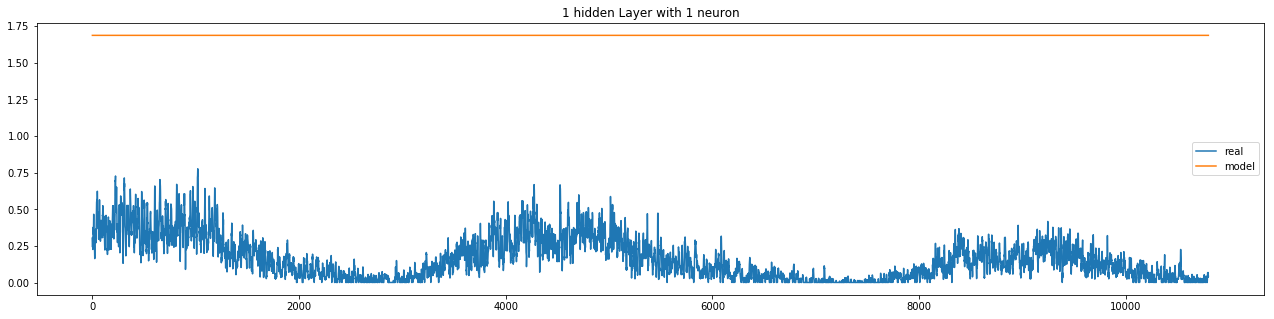

In [239]:
plt.figure(figsize=(22,5))

#plt.plot(X_test)
plt.plot(y_test)
plt.plot(y_pred_test_LSTM*110-10.08)

# plt.plot(X_train)
# plt.plot(y_pred2)
plt.legend(['real','model'])
plt.title('1 hidden Layer with 1 neuron')
#print('R-Squared: %f'%(r2_score(C)))

In [223]:
rmse(y_pred_test_LSTM,y_test)

0.1498773409205241